In [1]:
# Required imports
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input
from imblearn.over_sampling import SMOTE
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
# Load the dataset
data = pd.read_csv("./data/mcar.csv")

# Display the first few rows of the dataset to understand its structure
data.head()


,Unnamed: 0.1,Unnamed: 0,RID,lh.Cerebellum.White.Matter,lh.Cerebellum.Cortex,lh.Thalamus.Proper,lh.Caudate,lh.Putamen,lh.Pallidum,X3rd.Ventricle,...,adas_Q7SCORE,adas_Q8SCORE,adas_Q9SCORE,adas_Q10SCORE,adas_Q11SCORE,adas_Q12SCORE,adas_Q13SCORE,APOE4.0,APOE4.1,APOE4.2
0,4,4,69,1.042776,1.112264,1.267889,1.346736,2.233189,5.768378,1.248420,...,8,9,5,5,5,5,4,1.0,0.0,0
1,10,10,210,0.932077,1.052851,1.207376,1.109218,1.596830,2.150558,1.022413,...,8,10,5,5,5,5,4,1.0,0.0,0
2,11,11,337,1.040932,1.068165,0.880114,0.944061,2.541997,2.522598,0.358271,...,8,10,5,5,5,5,5,0.0,1.0,0
3,14,14,416,1.059263,1.165031,1.618939,0.744189,2.062818,1.027406,0.593939,...,8,11,5,5,5,5,5,1.0,0.0,0
4,50,50,2155,1.027046,1.152940,1.241443,1.089622,1.486336,3.192944,0.958194,...,8,10,5,5,5,5,5,0.0,0.0,1


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 559 entries, 0 to 558
Columns: 226 entries, Unnamed: 0.1 to APOE4.2
dtypes: float64(191), int64(35)
memory usage: 987.1 KB


In [5]:
# Drop the target and irrelevant columns to form the feature set
X = data.drop(columns=['RID','Unnamed: 0.1', 'Unnamed: 0'])
y = data['AD_LABEL']

In [6]:
y.value_counts()

1    363
2    137
3     59
Name: AD_LABEL, dtype: int64

In [7]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# Define the dimensions
input_dim = X_train.shape[1]
encoding_dim = int(input_dim / 2)  # Compress the features to half their original size

In [9]:
# Build the autoencoder model
input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim, activation="relu")(input_layer)
decoder = Dense(input_dim, activation="sigmoid")(encoder)

In [10]:
autoencoder = Model(inputs=input_layer, outputs=decoder)

In [11]:
# Compile the model
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

In [12]:
# Train the autoencoder
history = autoencoder.fit(X_train, X_train,
                          epochs=50,
                          batch_size=256,
                          shuffle=True,
                          validation_data=(X_val, X_val),
                          verbose=0)

In [13]:
# Extract the encoder part of the autoencoder
encoder_model = Model(inputs=input_layer, outputs=encoder)

# Transform the original features to get the compressed features
X_train_encoded = encoder_model.predict(X_train)
X_val_encoded = encoder_model.predict(X_val)

4/4 [==============================] - 0s 3ms/step


In [14]:
# Export the compressed features to a CSV file
"""compressed_features = pd.DataFrame(X_train_encoded)
compressed_features.to_csv('compressed_features.csv', index=True)
"""

"compressed_features = pd.DataFrame(X_train_encoded)\ncompressed_features.to_csv('compressed_features.csv', index=True)\n"

In [15]:
# Create an instance of SMOTE
smote = SMOTE()

# Apply SMOTE to the training data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_encoded, y_train)


In [16]:
y_train_resampled.value_counts()

1    286
2    286
3    286
Name: AD_LABEL, dtype: int64

In [17]:
# Convert labels to one-hot encoded format
y_train_onehot = to_categorical(y_train_resampled)

# Define the dimensions for the classifier
input_dim_classifier = X_train_resampled.shape[1]
output_dim_classifier = y_train_onehot.shape[1]

# Build the autoencoder-based classifier
input_layer_classifier = Input(shape=(input_dim_classifier,))
encoder_classifier = Dense(encoding_dim, activation="relu")(input_layer_classifier)
output_layer = Dense(output_dim_classifier, activation="softmax")(encoder_classifier)

autoencoder_classifier = Model(inputs=input_layer_classifier, outputs=output_layer)

# Compile the model
autoencoder_classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the classifier
history_classifier = autoencoder_classifier.fit(X_train_resampled, y_train_onehot,
                                                epochs=50,
                                                batch_size=256,
                                                shuffle=True,
                                                verbose=0)


In [18]:
# Define 5-fold cross-validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store performance metrics for each fold
accuracies = []
precisions = []
recalls = []
f1_scores = []

# Perform 5-fold cross-validation
for train_idx, test_idx in kfold.split(X_train_encoded, y_train):
    # Split data into training and testing sets for the current fold
    X_fold_train, X_fold_test = X_train_encoded[train_idx], X_train_encoded[test_idx]
    y_fold_train, y_fold_test = y_train.iloc[train_idx], y_train.iloc[test_idx]
    
    # Convert labels to one-hot encoded format
    y_fold_train_onehot = to_categorical(y_fold_train)
    
    # Train the autoencoder-based classifier for the current fold
    history_classifier = autoencoder_classifier.fit(X_fold_train, y_fold_train_onehot,
                                                    epochs=50,
                                                    batch_size=256,
                                                    shuffle=True,
                                                    verbose=0)
    
    # Predict the labels for the test set
    y_pred_probs = autoencoder_classifier.predict(X_fold_test)
    y_pred = np.argmax(y_pred_probs, axis=1)
    
    # Calculate performance metrics
    acc = accuracy_score(y_fold_test, y_pred)
    prec = precision_score(y_fold_test, y_pred, average='macro')
    rec = recall_score(y_fold_test, y_pred, average='macro')
    f1 = f1_score(y_fold_test, y_pred, average='macro')
    
    # Append metrics to the respective lists
    accuracies.append(acc)
    precisions.append(prec)
    recalls.append(rec)
    f1_scores.append(f1)

# Print the performance metrics for each fold
for i, (acc, prec, rec, f1) in enumerate(zip(accuracies, precisions, recalls, f1_scores), 1):
    print(f"Fold {i} - Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1-score: {f1:.4f}")


3/3 [==============================] - 0s 3ms/step
Fold 1 - Accuracy: 0.8000, Precision: 0.8024, Recall: 0.7473, F1-score: 0.7700
Fold 2 - Accuracy: 0.8222, Precision: 0.7844, Recall: 0.7650, F1-score: 0.7725
Fold 3 - Accuracy: 0.7640, Precision: 0.7976, Recall: 0.6833, F1-score: 0.7174
Fold 4 - Accuracy: 0.8315, Precision: 0.8502, Recall: 0.7496, F1-score: 0.7883
Fold 5 - Accuracy: 0.8315, Precision: 0.8480, Recall: 0.8206, F1-score: 0.8331


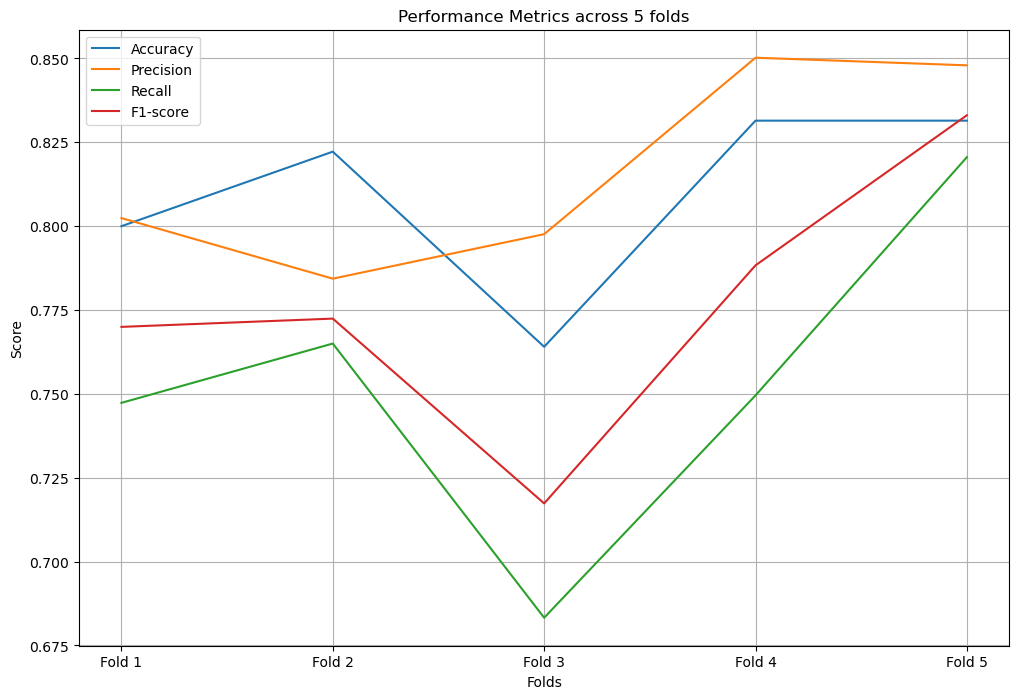

In [19]:
# Visualize the performance metrics
metrics = [accuracies, precisions, recalls, f1_scores]
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-score']

plt.figure(figsize=(12, 8))
for metric, name in zip(metrics, metric_names):
    plt.plot(metric, label=name)

plt.title("Performance Metrics across 5 folds")
plt.xlabel("Folds")
plt.ylabel("Score")
plt.xticks(ticks=range(5), labels=[f"Fold {i+1}" for i in range(5)])
plt.legend()
plt.grid(True)
plt.show()


In [20]:
from sklearn.metrics import classification_report

In [21]:
# Print the classification report for the current fold
print(f"Classification Report for Fold {i}:\n")
print(classification_report(y_fold_test, y_pred))


Classification Report for Fold 5:

              precision    recall  f1-score   support

           1       0.88      0.88      0.88        57
           2       0.67      0.70      0.68        23
           3       1.00      0.89      0.94         9

    accuracy                           0.83        89
   macro avg       0.85      0.82      0.83        89
weighted avg       0.84      0.83      0.83        89



In [22]:
# Calculate the confusion matrix
confusion = confusion_matrix(y_fold_test, y_pred)

# Number of classes
num_classes = 3

# Print the confusion matrix
print("Confusion Matrix:")
print(confusion)


Confusion Matrix:
[[50  7  0]
 [ 7 16  0]
 [ 0  1  8]]


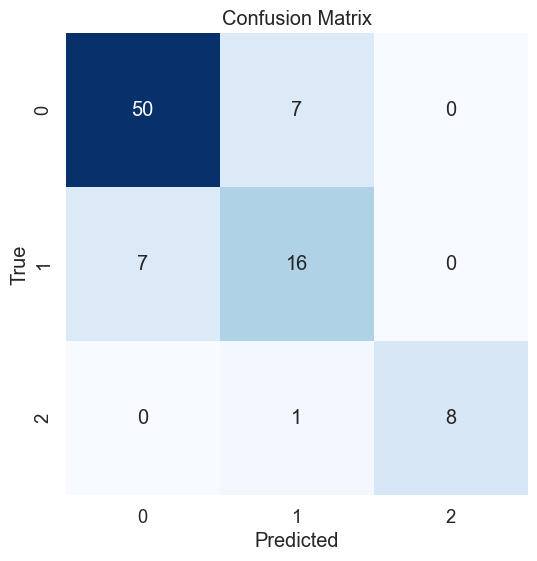

In [23]:
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2) 

sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False, square=True,
            xticklabels=range(num_classes), yticklabels=range(num_classes))

plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")

plt.show()


In [24]:
# Calculate the precision, recall, and F1-score for each class
for i in range(num_classes):
    class_precision = confusion[i, i] / max(1, sum(confusion[:, i]))
    class_recall = confusion[i, i] / max(1, sum(confusion[i, :]))
    class_f1 = 2 * (class_precision * class_recall) / max(1e-9, (class_precision + class_recall))
    
    print(f"Class {i + 1} - Precision: {class_precision:.2f}, Recall: {class_recall:.2f}, F1-Score: {class_f1:.2f}")


Class 1 - Precision: 0.88, Recall: 0.88, F1-Score: 0.88
Class 2 - Precision: 0.67, Recall: 0.70, F1-Score: 0.68
Class 3 - Precision: 1.00, Recall: 0.89, F1-Score: 0.94


In [25]:
accuracy = accuracy_score(y_fold_test, y_pred)

In [26]:
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.83
